In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Q7: Noisy signal

A convolution is defined as:  

\begin{equation}
  (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau \tag{1}  
\end{equation}  

It is easy to compute this with FFTs, via the _convolution theorem_,  

\begin{equation}  
  \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\} \tag{2}  
\end{equation}  

That is: the Fourier transform of the convolution of $f$ and $g$ is simply the product of the individual transforms of $f$ and $g$. This allows us to compute the convolution via multiplication in Fourier space and then take the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:

\begin{equation}  
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\} \tag{3}  
\end{equation}  

A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian. We'll do that here.

In [5]:
from scipy import signal

In [7]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

Here's some noisy data we'll work with

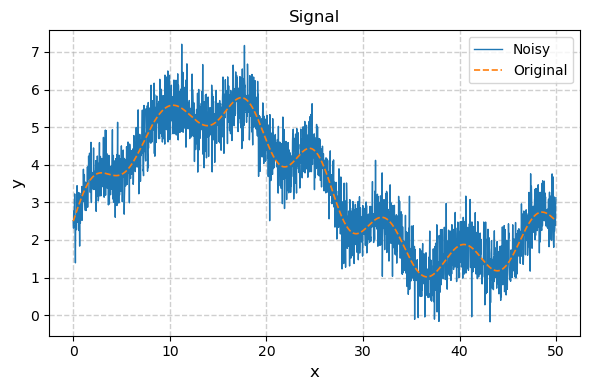

In [10]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(x, noisy, color='C0', linewidth=1, label=r'Noisy')
ax.plot(x, orig, color='C1', linestyle='--', linewidth=1.2, label=r'Original')

ax.set_title(r"Signal")
ax.set_xlabel(r"x", fontsize=12)
ax.set_ylabel(r"y", fontsize=12)

ax.legend(fontsize=10)
ax.grid(True, linestyle='--', linewidth=1, alpha=0.6)

plt.tight_layout()
plt.show()

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.windows.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

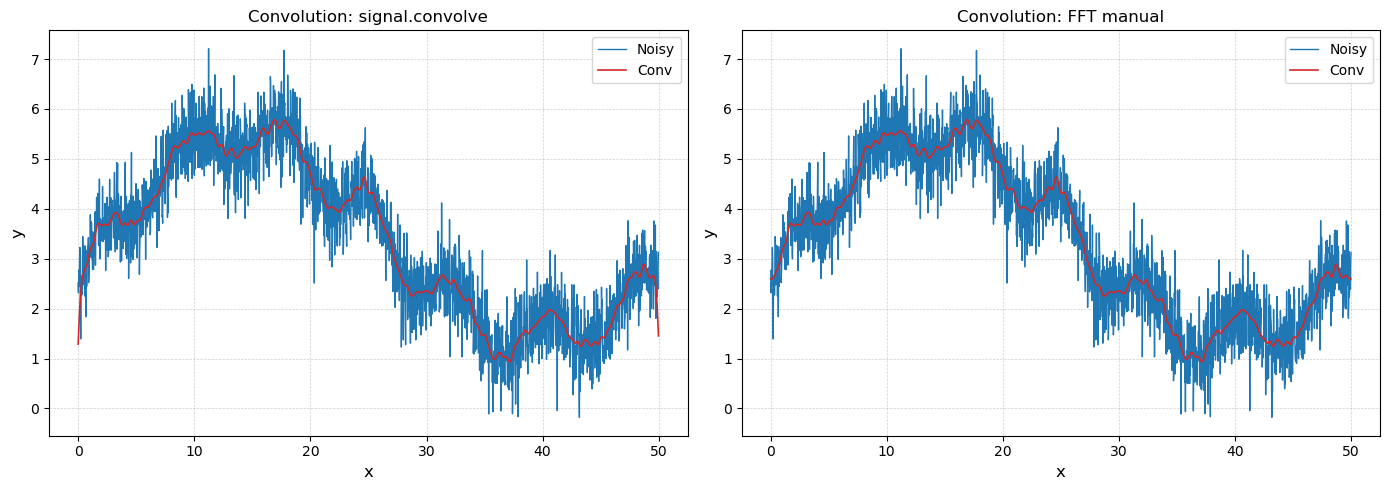

In [13]:
# --- Gaussian kernel ---
std = 7
kernel = signal.windows.gaussian(N, std, sym=True)
kernel /= sum(kernel) # normalize the kernel

# --- Convolution using signal.convolve ---
conv_direct = signal.convolve(noisy, kernel, mode='same')

# --- Convolution via FFT (manual implementation) ---
# np.roll centers the kernel so that its peak aligns with index 0 in Fourier space
kernel_fft = np.fft.fft(np.roll(kernel, -N//2))
noisy_fft = np.fft.fft(noisy)

# multiply in Fourier space, then inverse FFT
conv_fft = np.real(np.fft.ifft(noisy_fft * kernel_fft))

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Convolution with signal.convolve ---
ax = axes[0]
ax.plot(x, noisy, color='C0', linewidth=1, label=r'Noisy')
ax.plot(x, conv_direct, color='C3', linewidth=1.2, label=r'Conv')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_title(r"Convolution: signal.convolve")
ax.set_xlabel(r"x", fontsize=12)
ax.set_ylabel(r"y", fontsize=12)
ax.legend(fontsize=10)

# --- Convolution with manual FFT method ---
ax = axes[1]
ax.plot(x, noisy, color='C0', linewidth=1, label=r'Noisy')
ax.plot(x, conv_fft, color='C3', linewidth=1.2, label=r'Conv')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_title(r"Convolution: FFT manual")
ax.set_xlabel(r"x", fontsize=12)
ax.set_ylabel(r"y", fontsize=12)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

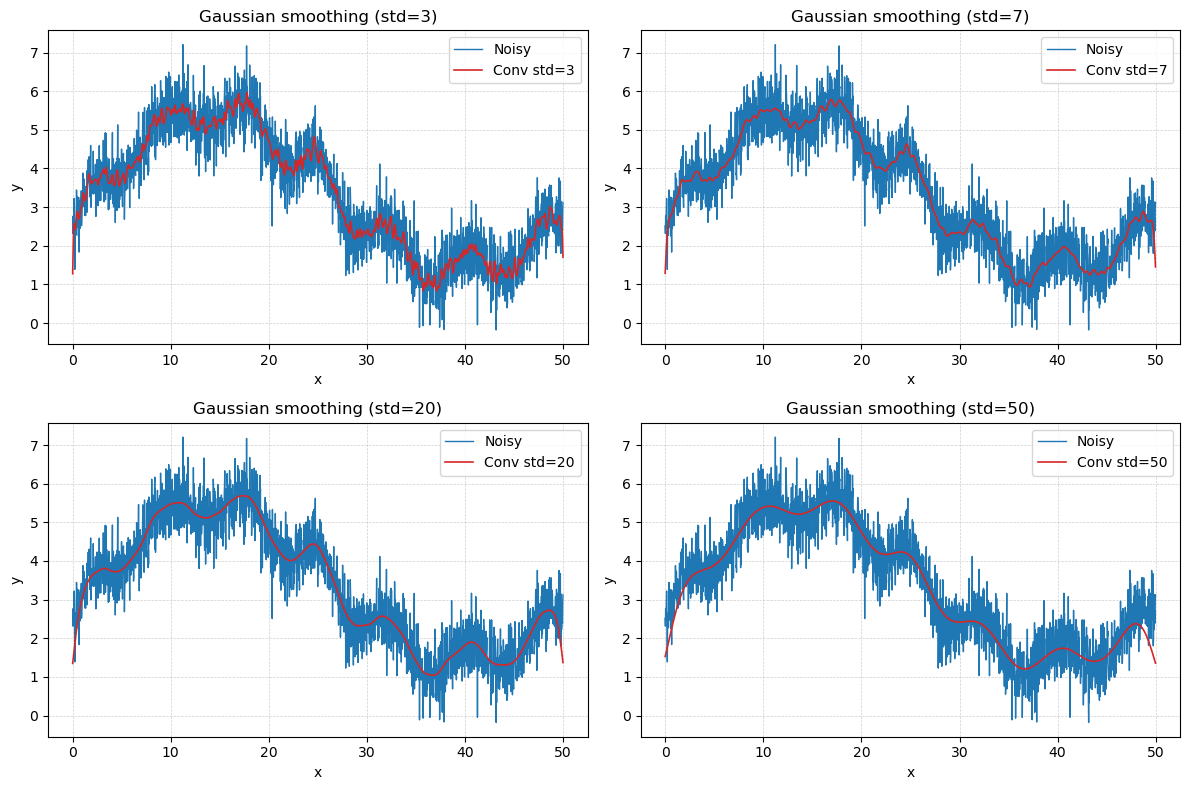

In [15]:
# --- Standard deviations to test ---
std_list = [3, 7, 20, 50]

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, std in enumerate(std_list):

    kernel = signal.windows.gaussian(N, std, sym=True)
    kernel /= kernel.sum()

    conv = signal.convolve(noisy, kernel, mode='same')

    ax = axes[i]
    ax.plot(x, noisy, color='C0', linewidth=1, label=r'Noisy')
    ax.plot(x, conv, color='C3', linewidth=1.2, label=f'Conv std={std}')
    # ax.plot(x, orig, color='C1', linestyle='--', linewidth=1, label=r'Original')

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_title(f"Gaussian smoothing (std={std})")
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [18]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [21]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

In [24]:
def power_spectrum(t, theta):
    """Return the power spectrum of theta in terms of angular frequency omega."""
    
    N = len(theta)
    dt = t[1] - t[0]
    
    # --- FFT ---
    # rfft returns only the positive-frequency components.
    theta_fft = np.fft.rfft(theta)
    
    # frequencies in Hz, only positive frequencies
    freq = np.fft.rfftfreq(N, dt)
    
    # convert to angular frequency
    omega = 2 * np.pi * freq

    # --- Normalization ---
    # multiply by 2/N because we are keeping only half of the spectrum (positive freqs).
    norm = 2.0 / N
    theta_fft *= norm

    # --- Power spectrum ---
    power = np.abs(theta_fft)**2
    
    return omega, power

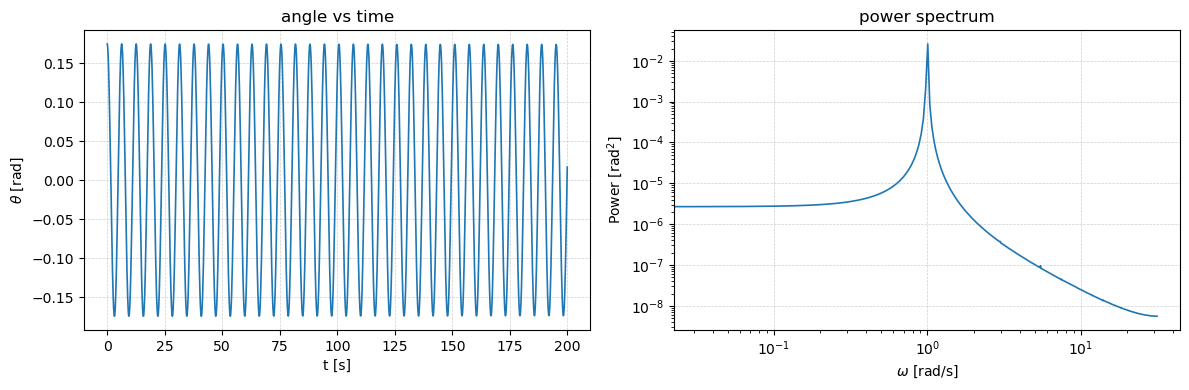

In [28]:
omega, power = power_spectrum(t, restrict_theta(y[0, :]))

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(t, restrict_theta(y[0, :]), linewidth=1.2)
ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$ [rad]")
ax.set_title("angle vs time")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

ax = axes[1]
ax.plot(omega, power, linewidth=1.2)
ax.set_xlabel(r"$\omega$ [rad/s]")
ax.set_ylabel("Power [rad$^2$]")
ax.set_title("power spectrum")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

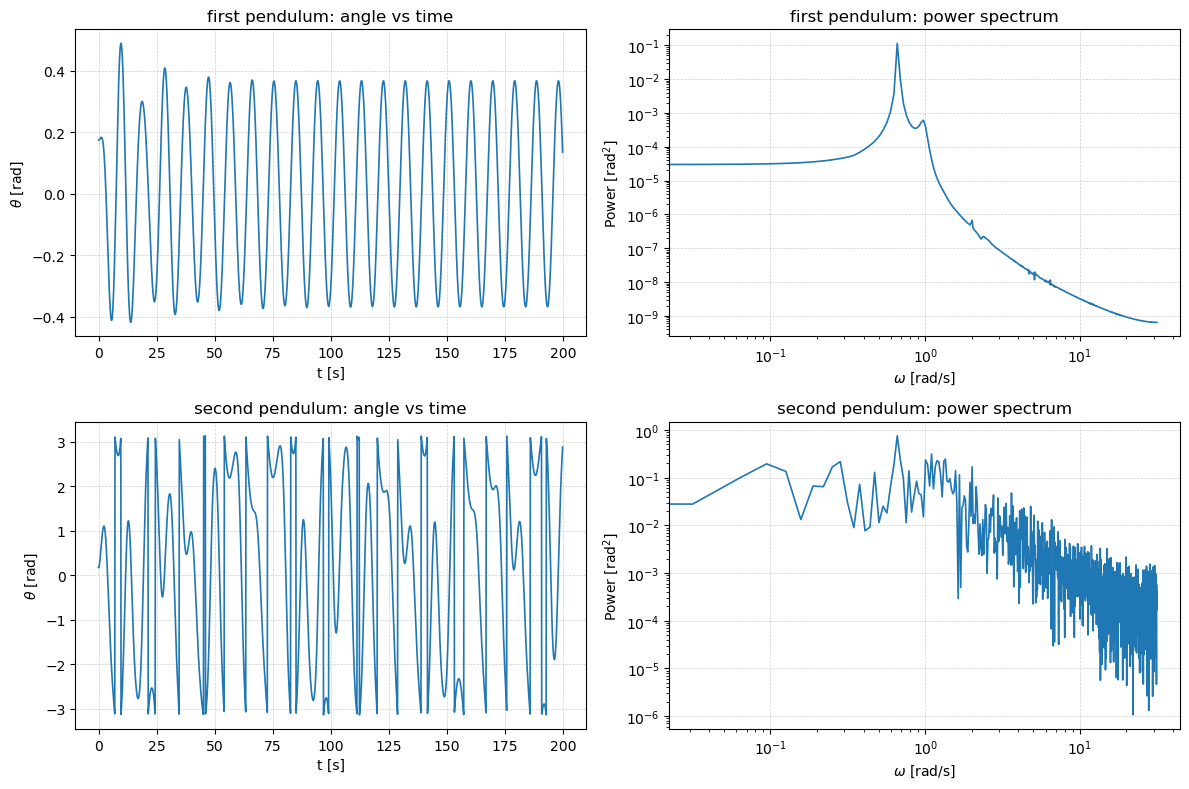

In [30]:
# --- Playing with parameters ---

# --- first pendulum ---
t1, y1 = int_pendulum(np.radians(10), 0.1, 2/3, 0.2, 200, 0.1)
omega1, power1 = power_spectrum(t1, restrict_theta(y1[0, :]))

# --- second pendulum ---
t2, y2 = int_pendulum(np.radians(10), 0.5, 2/3, 1.2, 200, 0.1)
omega2, power2 = power_spectrum(t2, restrict_theta(y2[0, :]))

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
ax.plot(t1, restrict_theta(y1[0, :]), linewidth=1.2)
ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$ [rad]")
ax.set_title("first pendulum: angle vs time")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

ax = axes[0, 1]
ax.plot(omega1, power1, linewidth=1.2)
ax.set_xlabel(r"$\omega$ [rad/s]")
ax.set_ylabel("Power [rad$^2$]")
ax.set_title("first pendulum: power spectrum")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

ax = axes[1, 0]
ax.plot(t2, restrict_theta(y2[0, :]), linewidth=1.2)
ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$ [rad]")
ax.set_title("second pendulum: angle vs time")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

ax = axes[1, 1]
ax.plot(omega2, power2, linewidth=1.2)
ax.set_xlabel(r"$\omega$ [rad/s]")
ax.set_ylabel("Power [rad$^2$]")
ax.set_title("second pendulum: power spectrum")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()